In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp
import shutil
from tensorflow.keras import applications
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

import pandas as pd
import numpy as np
import seaborn as sn

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
warnings.filterwarnings("ignore")
%matplotlib inline

Mounted at /content/drive


In [ ]:
epochs = 100
batch_size = 32
#testsplit = .2
targetx = 224
targety = 224
learning_rate = 0.0001
classes = 5
seed = random.randint(1, 1000)
dtrain_dir = '/content/drive/MyDrive/Diabetic Foot ulcer/Training'
valid_dir = '/content/drive/MyDrive/Diabetic Foot ulcer/Validation'

In [ ]:
datagen = ImageDataGenerator(
        shear_range=0.1,
        #rescale=1./255,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        preprocessing_function=preprocess_input
)

train_generator = datagen.flow_from_directory(
        dtrain_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed

)

validation_generator = datagen.flow_from_directory(
        valid_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed
)

Found 2600 images belonging to 5 classes.
Found 554 images belonging to 5 classes.


In [ ]:
checkpoint = ModelCheckpoint('MobileNetV2.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False
                             )

#tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                           # histogram_freq=0,
                            #batch_size=batch_size,
                            #write_graph=False,
                            #update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.lr))

def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=50,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

In [ ]:

import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam


In [ ]:
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.1)(x)
x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(seed), bias_initializer='zeros')(x)
x = Dropout(0.5)(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(learning_rate=learning_rate)
loss = "categorical_crossentropy"



model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])


In [ ]:
t=time.time()
history = model.fit(train_generator,

                                validation_data=validation_generator,

                                epochs=epochs,
                                callbacks=[reducelr])

#compute the training time
print('Training time: %s' % (time.time()-t))

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.4811 - loss: 1.2200 - val_accuracy: 0.7780 - val_loss: 0.6284 - learning_rate: 1.0000e-04
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 54s 658ms/step - accuracy: 0.7445 - loss: 0.6567 - val_accuracy: 0.8538 - val_loss: 0.4548 - learning_rate: 1.0000e-04
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 56s 678ms/step - accuracy: 0.8113 - loss: 0.5095 - val_accuracy: 0.8773 - val_loss: 0.3921 - learning_rate: 1.0000e-04
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 55s 676ms/step - accuracy: 0.8196 - loss: 0.4563 - val_accuracy: 0.9079 - val_loss: 0.3364 - learning_rate: 1.0000e-04
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 55s 673ms/step - accuracy: 0.8522 - loss: 0.4139 - val_accuracy: 0.8791 - val_loss: 0.3367 - learning_rate: 1.0000e-04
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 54s 656ms/step - accuracy: 0.8645 - loss: 0.3599 - val_accuracy: 0.9188 - val_loss: 0.2827 - learning_rate: 1.0000e-04
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 55s 676ms/step 

In [ ]:
 import matplotlib.pyplot as plt
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

acc = history.history['val_accuracy']
val_acc = history.history['accuracy']
val_loss = history.history['loss']
loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.style.use('seaborn-whitegrid') # Use a specific seaborn style like 'seaborn-whitegrid'

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.xlabel('Num of Epochs')
plt.ylabel('Accuracy')
plt.title(' DenseNet201 Training vs validation accuracy ')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('DenseNet201 Training vs validation loss ')
plt.xlabel('Num of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

OSError: 'seaborn-whitegrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [ ]:
 import matplotlib.pyplot as plt
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

acc = history.history['val_accuracy']
val_acc = history.history['accuracy']
val_loss = history.history['loss']
loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.style.use('seaborn')

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.xlabel('Num of Epochs')
plt.ylabel('Accuracy')
plt.title(' MobileNetV2 Training vs validation accuracy ')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('MobileNetV2 Training vs validation loss ')
plt.xlabel('Num of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

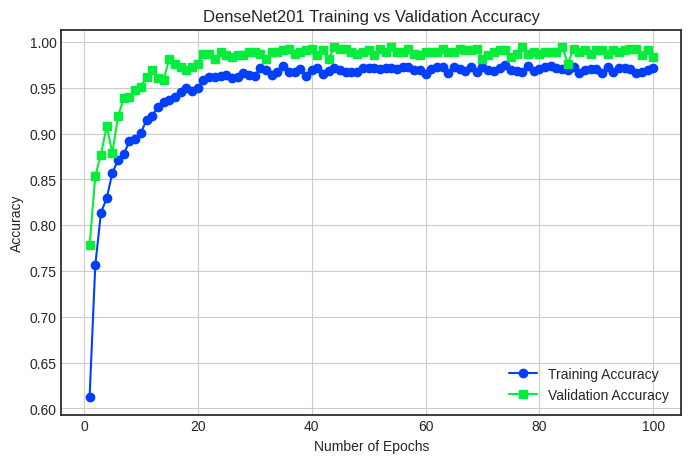

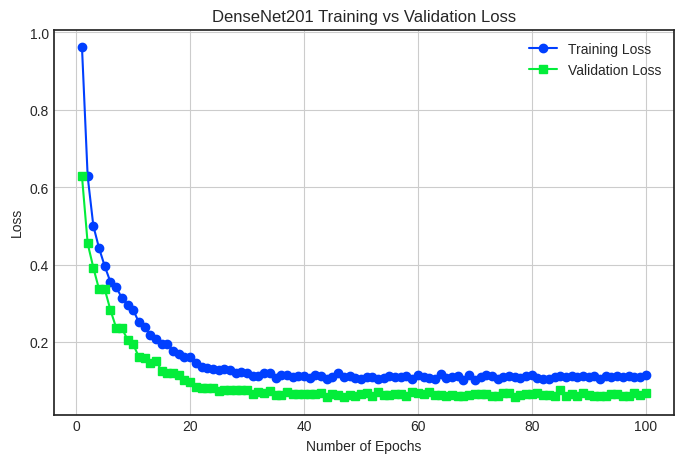

In [ ]:
import matplotlib.pyplot as plt

# Ensure history is available
if 'history' not in globals():
    raise ValueError("The variable 'history' is not defined. Ensure model.fit() has been run.")

# Use correct Matplotlib style
plt.style.use("seaborn-v0_8-bright")

# Extract values safely
acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

# Define epochs
epochs = range(1, len(acc) + 1)

# Check if data exists
if not acc or not loss:
    raise ValueError("Empty training history. Ensure model.fit() has been executed.")

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('DenseNet201 Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('DenseNet201 Training vs Validation Loss')
plt.legend()
plt.grid(True)

# Show plots
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/Diabetic Foot ulcer/deployment_model.h5")
print("model saved!!!")

model saved!!!


In [ ]:
import numpy as np
accuracy = np.array(acc)
print(' Training Accuracy of model is      :   '  , accuracy[-1]*100,'%' )

val_accuracy = np.array(val_acc)
print('  Validation  Accuracy of model is      :   '  , val_accuracy[-1]*100,'%' )

t_loss = np.array(loss)
print('training   loss of   model   is     :   ' , t_loss[-1]*100,'%')
val_loss = np.array(val_loss)
print('Validation  loss of   model  is     :   ' , val_loss[-1]*100,'%')

 Training Accuracy of model is      :    97.15384840965271 %
  Validation  Accuracy of model is      :    98.37545156478882 %
training   loss of   model   is     :    11.474362015724182 %
Validation  loss of   model  is     :    6.798999011516571 %


In [ ]:
data_dir1 = "/content/drive/MyDrive/Diabetic Foot ulcer/Testing"

datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        preprocessing_function=preprocess_input
)
val_suffle=False

test_generator = datagen.flow_from_directory(
        data_dir1,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False,

        #subset="test"
)
score = model.evaluate(test_generator, verbose=1)
print(score)

Found 555 images belonging to 5 classes.
18/18 ━━━━━━━━━━━━━━━━━━━━ 226s 13s/step - accuracy: 0.9909 - loss: 0.0344
[0.059147611260414124, 0.9819819927215576]


In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve,auc
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sn
def plot_multiclass_roc(y_pred, y_test, n_classes,class_label, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i,j in enumerate(class_label):
        print(i,j)
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = {}) for label {}'.format(np.round(roc_auc[i],2),j))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

In [ ]:
#Alexnet_model.evaluate(valid_set,steps=valid_set.n//batch_size)
#valid_set.reset()

model.evaluate(test,steps=test_generator.n//batch_size)
test_generator.reset()

y_pred = model.predict(test_generator, steps=int(np.ceil(test_generator.n / batch_size)), verbose=1)
class_label=list(test_generator.class_indices.keys())


if val_suffle==True:
  per = np.random.permutation(test_generator.n)
  test_generator.index_array = per
  y_true = test_generator.classes[per]
else:
  y_true = test_generator.classes


plot_multiclass_roc(y_pred, pd.get_dummies(y_true), n_classes=5, class_label=class_label, figsize=(10, 5))


NameError: name 'test' is not defined

In [ ]:
score = model.evaluate(test_generator, verbose=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 532ms/step - accuracy: 0.9944 - loss: 0.0334


In [ ]:
test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

18/18 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step
Classification Report
                                 precision    recall  f1-score   support

            Grade_0 Intact skin       1.00      1.00      1.00       111
      Grade_1 Superficial ulcer       0.99      1.00      1.00       111
   Grade_2 Deep ulcer to tendon       0.97      0.96      0.97       111
Grade_3 Deep ulcer with abscess       0.98      0.97      0.98       111
    Grade_4 Whole foot gangrene       0.99      1.00      1.00       111

                       accuracy                           0.99       555
                      macro avg       0.99      0.99      0.99       555
                   weighted avg       0.99      0.99      0.99       555



18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 901ms/step


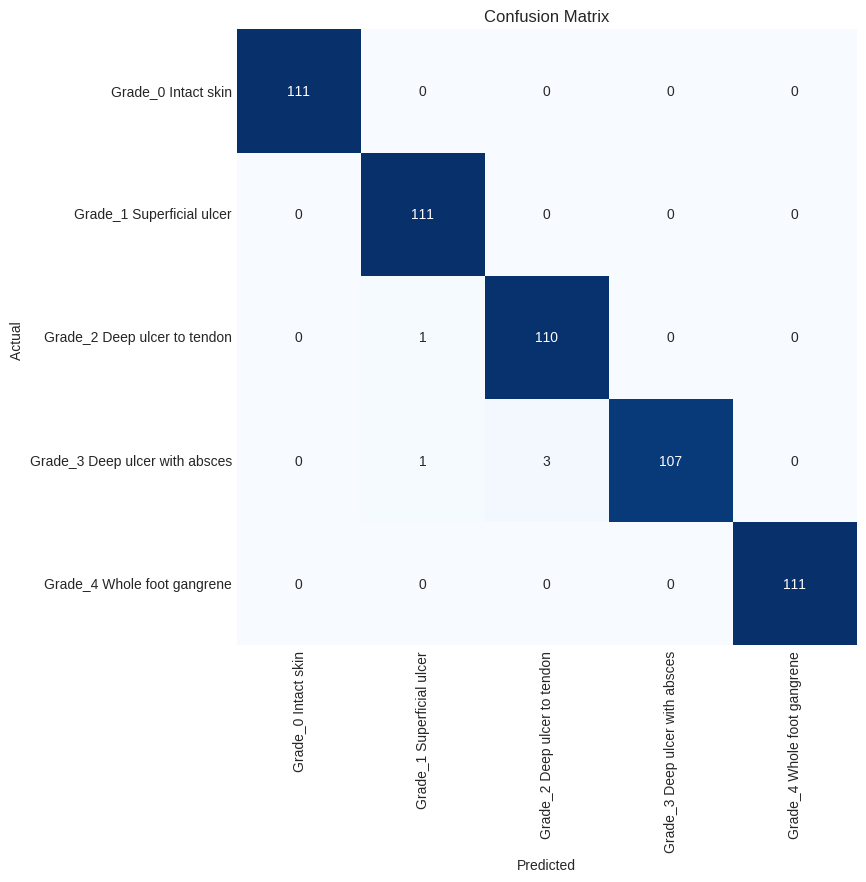

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
classes=['Grade_0 Intact skin', 'Grade_1 Superficial ulcer', 'Grade_2 Deep ulcer to tendon','Grade_3 Deep ulcer with absces','Grade_4 Whole foot gangrene']

preds=model.predict(test_generator)
y_pred=[]
y_true=[]
for i, p in enumerate(preds):
    y_pred.append(np.argmax(p))
    y_true.append(test_generator.labels[i])
y_pred=np.array(y_pred)
y_true=np.array(y_true)
cm = confusion_matrix(y_true, y_pred )
clr = classification_report(y_true, y_pred, target_names=classes)
length=len(classes)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(length)+.5, classes, rotation= 90)
plt.yticks(np.arange(length)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual ")
plt.title("Confusion Matrix")
plt.show()